### Task 1: Extract insights from data

                                                text    category
0  THIS IS MASSIVE Australian Senator Malcolm Rob...  CONSPIRACY
1  “ I ’m deeply concerned that the push to vacci...    CRITICAL
2  2021 : They wanted to know your vaccination st...    CRITICAL
3  Anthony Fauci once again defended brutal Chine...    CRITICAL
4  Proof has emerged showing that death from Wuha...    CRITICAL


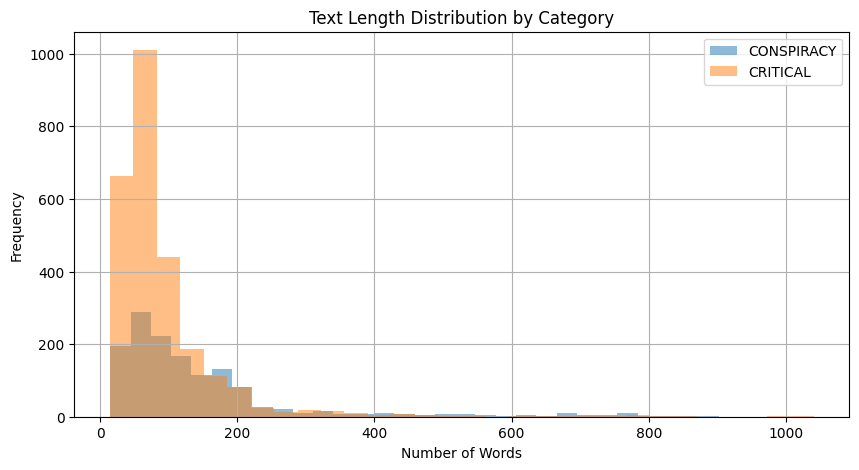

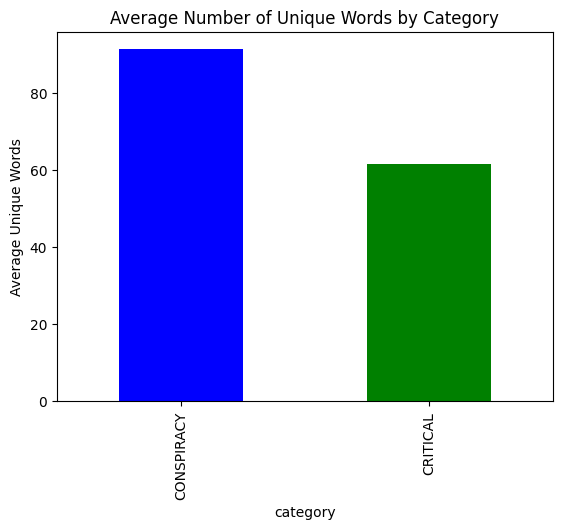

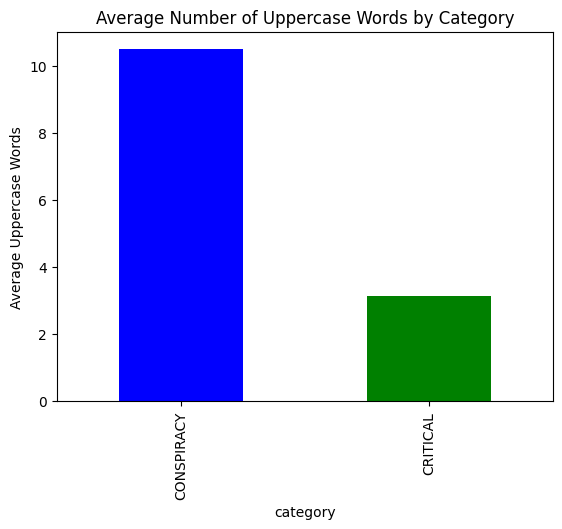

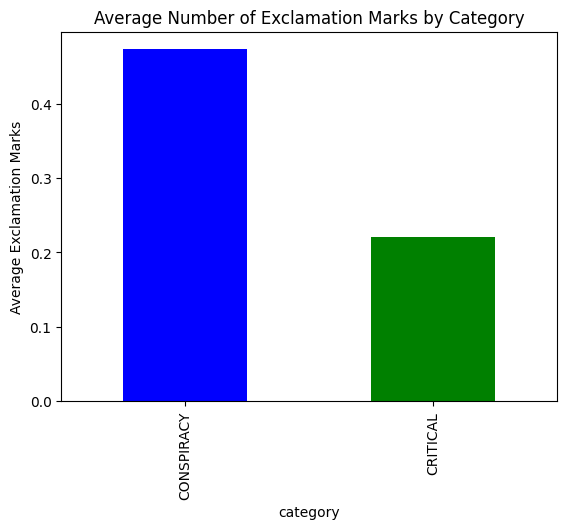

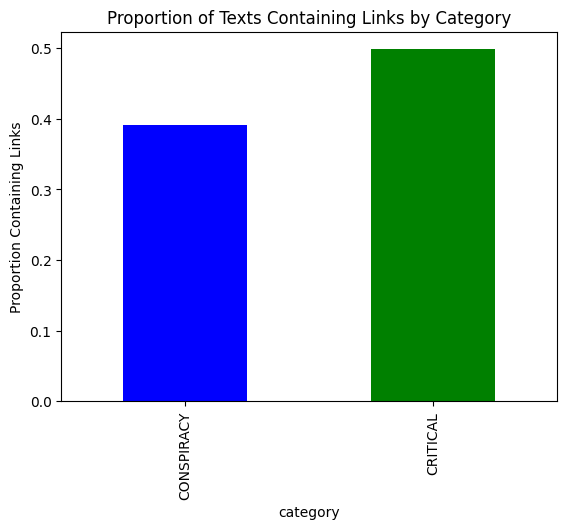

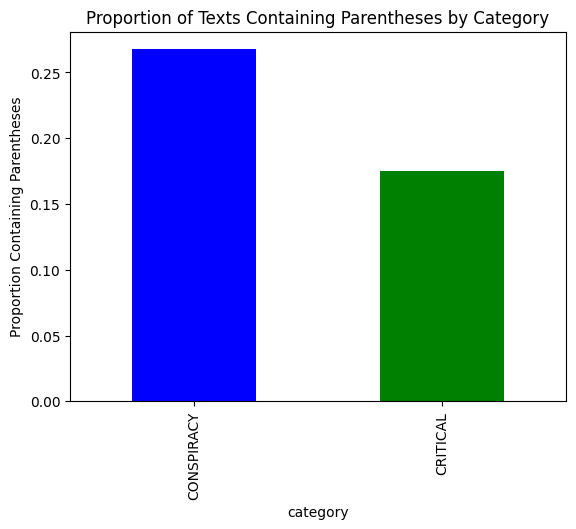

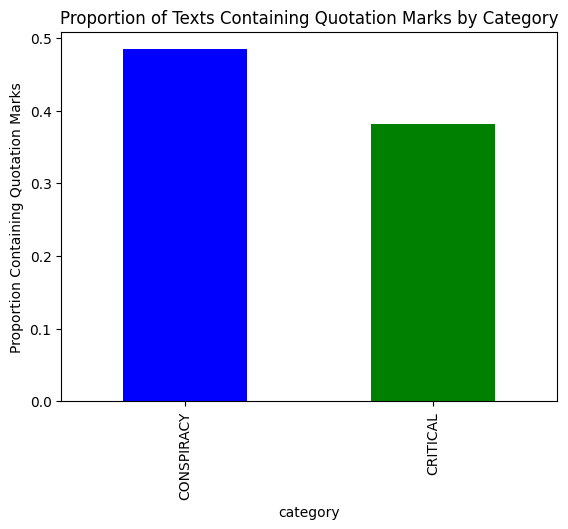

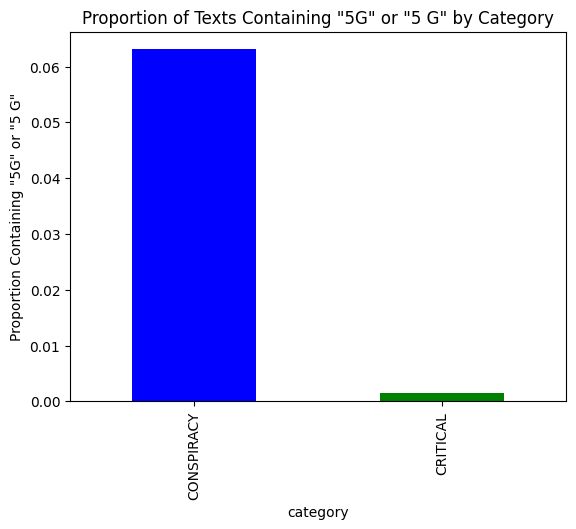

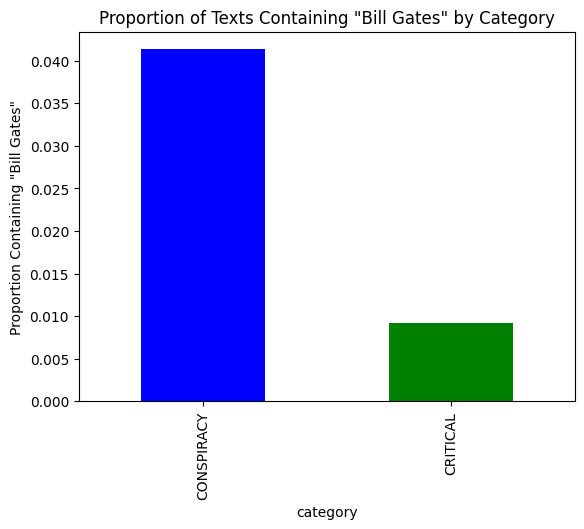

In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data with utf-8 encoding, ensuring every character is beautifully preserved
with open('Oppositional_thinking_analysis_dataset.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Extract only the text and the category for the DataFrame
data_extracted = [{'text': entry['text'], 'category': entry['category']} for entry in data]

# Convert the refined list to a DataFrame
df = pd.DataFrame(data_extracted)

# Display the first few rows of the DataFrame
print(df.head())

# Extract text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

# Plot text length distribution
plt.figure(figsize=(10, 5))
df[df['category'] == 'CONSPIRACY']['text_length'].hist(alpha=0.5, label='CONSPIRACY', bins=30)
df[df['category'] == 'CRITICAL']['text_length'].hist(alpha=0.5, label='CRITICAL', bins=30)
plt.legend()
plt.title('Text Length Distribution by Category')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Count unique words
def count_unique_words(text):
    return len(set(text.split()))

df['unique_word_count'] = df['text'].apply(count_unique_words)

# Bar chart for unique word count
unique_words_by_category = df.groupby('category')['unique_word_count'].mean()
unique_words_by_category.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Number of Unique Words by Category')
plt.ylabel('Average Unique Words')
plt.show()

# Count uppercase words
def count_uppercase_words(text):
    return sum(1 for word in text.split() if word.isupper())

df['uppercase_word_count'] = df['text'].apply(count_uppercase_words)

# Compare the number of uppercase words between the categories
uppercase_words_by_category = df.groupby('category')['uppercase_word_count'].mean()

# Bar chart for uppercase word count
uppercase_words_by_category.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Number of Uppercase Words by Category')
plt.ylabel('Average Uppercase Words')
plt.show()

# Count exclamation marks
def count_exclamations(text):
    return text.count('!')

df['exclamation_count'] = df['text'].apply(count_exclamations)

# Compare the number of exclamation marks between the categories
exclamations_by_category = df.groupby('category')['exclamation_count'].mean()

# Bar chart for exclamation mark count
exclamations_by_category.plot(kind='bar', color=['blue', 'green'])
plt.title('Average Number of Exclamation Marks by Category')
plt.ylabel('Average Exclamation Marks')
plt.show()

# Check if text contains a link starting with "http"
df['contains_link'] = df['text'].apply(lambda x: 'http' in x)

# Check if text contains parentheses
df['contains_parentheses'] = df['text'].apply(lambda x: '(' in x or ')' in x)

# Check if text contains quotation marks
df['contains_quotation_marks'] = df['text'].apply(lambda x: '"' in x or "'" in x)

# Check if text contains "5G" or "5 G"
df['contains_5G'] = df['text'].apply(lambda x: '5G' in x or '5 G' in x)

# Check if text contains "Bill Gates"
df['contains_bill_gates'] = df['text'].apply(lambda x: 'Bill Gates' in x)

# Function to plot bar charts for different features, for the sake of beautiful visualization
def plot_feature_by_category(feature, title, ylabel):
    feature_by_category = df.groupby('category')[feature].mean()
    feature_by_category.plot(kind='bar', color=['blue', 'green'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

# Plot bar charts for each feature
plot_feature_by_category('contains_link', 'Proportion of Texts Containing Links by Category', 'Proportion Containing Links')
plot_feature_by_category('contains_parentheses', 'Proportion of Texts Containing Parentheses by Category', 'Proportion Containing Parentheses')
plot_feature_by_category('contains_quotation_marks', 'Proportion of Texts Containing Quotation Marks by Category', 'Proportion Containing Quotation Marks')
plot_feature_by_category('contains_5G', 'Proportion of Texts Containing "5G" or "5 G" by Category', 'Proportion Containing "5G" or "5 G"')
plot_feature_by_category('contains_bill_gates', 'Proportion of Texts Containing "Bill Gates" by Category', 'Proportion Containing "Bill Gates"')

### Task 2: Pre-processing

### Task 3: Text classification

### Task 4: Textual similarity

### Bonus Task: Textual similarity